# Library imports

In [55]:
## Vertex AI
import vertexai
from vertexai.generative_models import GenerativeModel, Part

## Google 
from google.cloud import storage
from google.cloud import vision
from google.api_core.client_options import ClientOptions

## Image processing
from scipy.signal import find_peaks
from PIL import Image
import cv2

## Text processing
from Levenshtein import distance
from thefuzz import fuzz

## General purpose
import matplotlib.pyplot as plt
from time import sleep
import numpy as np
import io
import re

# Authentication

In [56]:
project_id = "possible-arch-424719-s5"
vertexai.init(project=project_id, location="us-central1")

# Google Cloud Storage

In [57]:
def upload_to_gcs(source_file_path, destination_blob_name):
    bucket_name = "york-project"
    destination_blob_name = source_file_path.split("/")[-1]    

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    print(f"Uploading {source_file_path} to {destination_blob_name} in bucket {bucket_name}")

    blob.upload_from_filename(source_file_path)
    print(f"File {source_file_path} uploaded to {destination_blob_name}.")
    
    img_uri = f"gs://{bucket_name}/{destination_blob_name}"
    print(f"Google Storage URI: {img_uri}")
    return img_uri

# Gemini initialization

## Model parameters

In [58]:
generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.95,
}

## Model prediction

In [59]:
def generate(prompt, image_path):
    image_path = "gs://york-project/" + image_path.split("/")[-1]
    image = Part.from_uri(image_path, "image/png")

    model = GenerativeModel(
        "gemini-1.5-flash-001",
    )

    responses = model.generate_content(
        [prompt, image],        
        generation_config=generation_config,
        stream=True,
    )

    response = []
    for text in responses:
        try:
            response.append(text.text)
        except Exception as e:
            print(f"Error: {e}")
        
    text_response = "".join(response)
    return text_response

# OCR

## Paragraph OCR

In [60]:
def extract_paragraphs(annotation):
    """Extracts paragraphs and their bounding boxes from the annotation."""
    paragraphs = []
    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                paragraph_text = ' '.join(
                    ''.join(symbol.text for symbol in word.symbols)
                    for word in paragraph.words
                )

                bounds = [(vertex.x, vertex.y) for vertex in paragraph.bounding_box.vertices]
                paragraphs.append({"text": paragraph_text.strip(), "bounds": [bounds[0], bounds[2]]})
    return paragraphs

def detect_text(image, project_id):
    client_options = ClientOptions(quota_project_id=project_id)
    client = vision.ImageAnnotatorClient(client_options=client_options)

    response = client.document_text_detection(image=image)
    paragraphs = extract_paragraphs(response.full_text_annotation)
    return paragraphs

## Box highlighting / removal

In [61]:
def highlight_boxes(original_image, boxes, thickness=2):
    ordered_boxes = sorted(boxes, key=lambda x: x['bounds'][0][1])

    image = original_image.copy()
    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
        return None

    height, width, _ = image.shape

    for detected_text in ordered_boxes:
        bounds = detected_text['bounds']
        # Coordinates of the bounding box
        x_min, y_min, x_max, y_max = map(int, [bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]])

        # Determine the color of the rectangle
        if thickness == -1:
            y = y_max + 2 if y_max + 2 < height else y_min - 2
            color = tuple(map(int, image[y, x_min + (x_max - x_min) // 2]))
        else:
            color = (0, 0, 255) # Red (BGR)

        # Draw the rectangle on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

    return image

## NMS

In [62]:
def non_max_suppression(boxes, overlap_thresh):
    if len(boxes) == 0:
        return []

    # Convert bounding boxes to numpy array format
    boxes_np = np.array([
        [min([vertex[0] for vertex in box['bounds']]), 
         min([vertex[1] for vertex in box['bounds']]), 
         max([vertex[0] for vertex in box['bounds']]), 
         max([vertex[1] for vertex in box['bounds']])]
        for box in boxes
    ])

    x1, y1, x2, y2 = boxes_np[:, 0], boxes_np[:, 1], boxes_np[:, 2], boxes_np[:, 3]

    # Compute the area of the bounding boxes and sort by the bottom-right y-coordinate
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    pick = []

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start and the smallest (x, y) coordinates for the end
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes with overlap greater than the threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return [boxes[i] for i in pick]

## Merge overlapping boxes

In [63]:
def compute_iou(box1, box2):
    x1_1, y1_1 = box1[0]
    x2_1, y2_1 = box1[1]
    x1_2, y1_2 = box2[0]
    x2_2, y2_2 = box2[1]

    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(x1_1, x1_2)
    yA = max(y1_1, y1_2)
    xB = min(x2_1, x2_2)
    yB = min(y2_1, y2_2)

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    box1Area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2Area = (x2_2 - x1_2) * (y2_2 - y1_2)

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(box1Area + box2Area - interArea)

    return iou

In [64]:
import numpy as np

def compute_iou(box1, box2):
    x1 = max(box1[0][0], box2[0][0])
    y1 = max(box1[0][1], box2[0][1])
    x2 = min(box1[1][0], box2[1][0])
    y2 = min(box1[1][1], box2[1][1])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[1][0] - box1[0][0]) * (box1[1][1] - box1[0][1])
    box2_area = (box2[1][0] - box2[0][0]) * (box2[1][1] - box2[0][1])
    denominator = box1_area + box2_area - inter_area

    iou = inter_area / float(denominator) if denominator > 0 else 0
    return iou

def is_vertically_aligned(box1, box2, pixel_threshold=5, max_y_distance=10):
    # Sort the boxes by their Y coordinates
    box1, box2 = sorted([box1, box2], key=lambda x: x[0][1])
    x1_center = (box1[0][0] + box1[1][0]) / 2
    x2_center = (box2[0][0] + box2[1][0]) / 2

    y_distance = abs(box1[1][1] - box2[0][1])

    return abs(x1_center - x2_center) <= pixel_threshold and y_distance <= max_y_distance

def merge_boxes(original_boxes, threshold=0.5, pixel_threshold=5, max_y_distance=10):
    boxes = original_boxes.copy()

    if len(boxes) == 0:
        return []

    merged_boxes = []

    while boxes:
        base_box = boxes.pop(0)
        base_bounds = base_box['bounds']
        base_text = base_box['text']

        i = 0
        while i < len(boxes):
            if (compute_iou(base_bounds, boxes[i]['bounds']) > threshold or
                is_vertically_aligned(base_bounds, boxes[i]['bounds'], pixel_threshold, max_y_distance)):
                # Merge the boxes
                x1 = min(base_bounds[0][0], boxes[i]['bounds'][0][0])
                y1 = min(base_bounds[0][1], boxes[i]['bounds'][0][1])
                x2 = max(base_bounds[1][0], boxes[i]['bounds'][1][0])
                y2 = max(base_bounds[1][1], boxes[i]['bounds'][1][1])
                merged_bounds = [(x1, y1), (x2, y2)]
                base_text += ' ' + boxes[i]['text']
                base_bounds = merged_bounds
                boxes.pop(i)
            else:
                i += 1

        merged_boxes.append({"text": base_text.strip(), "bounds": base_bounds})

    return merged_boxes

## Vertical sectionning

In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def convert_to_grayscale(image):
    """Convert the image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_canny_edge_detection(gray_image, threshold1, threshold2):
    """Apply Canny edge detection to the grayscale image."""
    return cv2.Canny(gray_image, threshold1, threshold2, apertureSize=3)

def compute_vertical_sum(edges):
    """Compute the sum of pixel values along the vertical axis."""
    return np.sum(edges, axis=0)

def compute_horizontal_sum(edges):
    """Compute the sum of pixel values along the horizontal axis."""
    return np.sum(edges, axis=1)

def normalize_vertical_sum(vertical_sum):
    """Normalize the vertical sum to the range 0 to 255."""
    return (vertical_sum / np.max(vertical_sum)) * 255

def normalize_horizontal_sum(horizontal_sum):
    """Normalize the horizontal sum to the range 0 to 255."""
    return (horizontal_sum / np.max(horizontal_sum)) * 255

def find_significant_peaks(vertical_sum_normalized, height, distance):
    """Use find_peaks to identify significant peaks."""
    peaks, _ = find_peaks(vertical_sum_normalized, height=height, distance=distance)
    return peaks

def draw_boundaries(image, peaks):
    """Draw vertical lines at the positions of the detected peaks."""
    boundary_image = image.copy()
    v_peaks, h_peaks = peaks
    for peak in v_peaks:
        cv2.line(boundary_image, (peak, 0), (peak, boundary_image.shape[0]), (255, 0, 0), 2)
    for peak in h_peaks:
        cv2.line(boundary_image, (0, peak), (boundary_image.shape[1], peak), (0, 255, 0), 2)
    return boundary_image

def validate_peaks(peaks, img_bound, min_section_ratio, vertical=False):
    # Ensure the first section starts at the beginning of the image
    if (len(peaks) == 0):
        peaks = np.array([0])
        
    if (peaks[0] != 0):
        peaks = np.insert(peaks, 0, 0)
    
    # Ensure the last section ends at the end of the image
    if peaks[-1] != img_bound:
        peaks = np.append(peaks, img_bound)
    
    # Filter out sections that are too small
    min_section_size = min_section_ratio * img_bound  # Ratio of the image (10%, 15%...)
    valid_peaks = [peaks[0]]  # Always include the first peak

    i = 1
    while i < len(peaks) - 1:
        prev_peak_dist = peaks[i] - valid_peaks[-1]
        last_peak_dist = peaks[-1] - peaks[i]
        if prev_peak_dist >= min_section_size and last_peak_dist >= min_section_size:
            valid_peaks.append(peaks[i])
        i += 1

    # Always include the last peak
    valid_peaks.append(peaks[-1])
    return np.array(valid_peaks)

def detect_sections_refined(cleaned_img, canny_threshold1=50, canny_threshold2=150, peak_height=100, peak_distance=100, min_section_ratio=0.1):
    """Detects vertical sections in an image by identifying significant peaks in the vertical sum of edge-detected pixels."""
    
    # Convert the image to grayscale
    gray = convert_to_grayscale(cleaned_img)
    
    # Use Canny edge detection
    edges = apply_canny_edge_detection(gray, canny_threshold1, canny_threshold2)
    
    # Sum pixel values along the vertical axis
    vertical_sum = compute_vertical_sum(edges)

    # Sum pixel values along the horizontal axis
    horizontal_sum = compute_horizontal_sum(edges)
    
    # Normalize the vertical sum to the range 0 to 255
    vertical_sum_normalized = normalize_vertical_sum(vertical_sum)

    # Normalize the horizontal sum to the range 0 to 255
    horizontal_sum_normalized = normalize_horizontal_sum(horizontal_sum)
    
    # Use find_peaks to identify significant peaks
    v_peaks = find_significant_peaks(vertical_sum_normalized, peak_height, peak_distance)
    h_peaks = find_significant_peaks(horizontal_sum_normalized, peak_height, peak_distance)

    v_peaks = validate_peaks(v_peaks, cleaned_img.shape[1], min_section_ratio)
    h_peaks = validate_peaks(h_peaks, cleaned_img.shape[0], min_section_ratio)

    return [v_peaks, h_peaks]

## Generate boxes from peaks

In [66]:
def get_boxes(peaks, to_merge = []):
    v_peaks, h_peaks = peaks

    boxes = []
    for j in range(len(h_peaks) - 1):
        for i in range(len(v_peaks) - 1):
            x1 = v_peaks[i]
            y1 = h_peaks[j]
            x2 = v_peaks[i + 1]
            y2 = h_peaks[j + 1]
            boxes.append({"bounds": [(x1, y1), (x2, y2)]})

    merge_idx = []
    for merge_coords in to_merge:
        for i in range(len(boxes) - 1):
            print(boxes[i]["bounds"], merge_coords, boxes[i+1]["bounds"], merge_coords)
            if (boxes[i]["bounds"][1] == merge_coords):
                if (boxes[i+1]["bounds"][0][0] == merge_coords[0] and boxes[i+1]["bounds"][1][1] == merge_coords[1]):
                    merge_idx.append((i, i+1))

    for idx_couple in merge_idx[::-1]:
        boxes[idx_couple[0]]["bounds"] = [
            boxes[idx_couple[0]]["bounds"][0],
            boxes[idx_couple[1]]["bounds"][1]
        ]
        boxes.pop(idx_couple[1])

    return boxes

## Paragraph re-ordering

In [67]:
def group_boxes_by_row(boxes, y_threshold=10):
    """Group bounding boxes into rows based on y-coordinate."""
    rows = []
    current_row = []
    prev_y = None
    
    for box in boxes:
        if prev_y is None or abs(box['bounds'][0][1] - prev_y) <= y_threshold:
            current_row.append(box)
        else:
            rows.append(current_row)
            current_row = [box]
        prev_y = box['bounds'][0][1]
    
    if current_row:
        rows.append(current_row)
    
    return rows

def sort_rows_by_x(rows):
    """Sort each row of bounding boxes by x-coordinate."""
    for row in rows:
        row.sort(key=lambda box: box['bounds'][0][0])
    return rows

def sort_bounding_boxes(boxes):
    """Sort bounding boxes by y-coordinate (top to bottom) and x-coordinate (left to right) within each row."""
    boxes.sort(key=lambda box: box['bounds'][0][1])
    
    rows = group_boxes_by_row(boxes)
    sorted_rows = sort_rows_by_x(rows)
    
    # Flatten the sorted rows into a single list
    sorted_boxes = [box for row in sorted_rows for box in row]
    
    return sorted_boxes

## Section assignment

In [68]:
def calculate_overlap_area(box1, box2):
    x1 = max(box1[0][0], box2[0][0])
    y1 = max(box1[0][1], box2[0][1])
    x2 = min(box1[1][0], box2[1][0])
    y2 = min(box1[1][1], box2[1][1])

    overlap_width = max(0, x2 - x1)
    overlap_height = max(0, y2 - y1)

    return overlap_width * overlap_height

def assign_sections_and_collect_text(text_boxes, section_peaks):
    section_boxes = get_boxes(section_peaks)
    to_merge = []

    for i in range(len(text_boxes)):
        box = text_boxes[i]
        box_bounds = box['bounds']
        box_area = ((box_bounds[1][0] - box_bounds[0][0]) * (box_bounds[1][1] - box_bounds[0][1]))
        text_rec_overlap = []

        for rect_id in range(len(section_boxes)):
            rect_bounds = section_boxes[rect_id]["bounds"]
            overlap_area = calculate_overlap_area(box_bounds, rect_bounds)

            percent_overlap = overlap_area / box_area
            text_rec_overlap.append(percent_overlap)

        overlap = np.array(text_rec_overlap)
        box["section_id"] = np.argmax(overlap)
        lower_bound = overlap > 0.3; upper_bound = overlap < 0.7
        tests = lower_bound * upper_bound
        
        if (sum(tests) > 1):
            section_indexes = np.where(tests)[0]
            box["section_id"] = section_indexes[0]

            new_h_peaks = list(section_peaks[1]) + [box_bounds[1][1]]
            section_peaks[1] = np.sort(new_h_peaks); section_peaks_len_1 = len(section_peaks[1])
            section_peaks[1] = validate_peaks(section_peaks[1], section_peaks[1][-1], 0.1); section_peaks_len_2 = len(section_peaks[1])

            if (section_peaks_len_1 == section_peaks_len_2):
                to_merge.append((section_boxes[section_indexes[0]]["bounds"][1][0], box_bounds[1][1]))
                section_boxes = get_boxes(section_peaks, to_merge)


    section_texts = ['' for _ in range(len(section_boxes))]
    for box in text_boxes:
        section_id = box["section_id"]
        if section_id < len(section_texts):
            section_texts[section_id] += box['text'] + '\n'

    return section_texts, section_boxes

def process_text_sections(text_boxes, sections, rectangles_bbox):
    section_texts, section_boxes = assign_sections_and_collect_text(text_boxes, sections)
    return section_texts, sections, section_boxes

# Gemini predictions

## Prediction

In [69]:
prompt_basis = f"""
    ### INSTRUCTION
    Find a relevant citation that can help answer the question and cite it in CITATION: and explain it in EXPLANATION:
    Only use text that could be found in the image, not in the question, and only if it helps answer the question.
    If the text is not a question or if the image does not contain the answer or a cue, write "No answer".
    The explanation should be a sentece that shows why the citation is relevant.
    ### OUTPUT 
    CITATION: <citation>
    EXPLANATION: <explanation>
    ### FORMATTING
    In case of multiple usefull citations, separate them with <sep>.
    The citation must be text from the image that is ON THE SAME LINE, NO RETURNS. No more than 5 words.
    ### EXAMPLE
    CITATION: Energy is conserved.<sep>Mass is conserved.
    EXPLANATION: Energy and mass are conserved in the process. Which would indicate that the process is a closed system.
    ### QUESTION
    
"""

In [70]:
def ask_question(question, img_uri):
    prompt = prompt_basis + question

    response = generate(prompt, img_uri)
    return response

## Output parsing

In [71]:
def extract_citation(response):
    cit_match = re.search(r"CITATION: (.+)", response)
    explanation_match = re.search(r"EXPLANATION: (.+)", response)
    if cit_match and explanation_match:
        return cit_match.group(1), explanation_match.group(1)
    return None, None

In [72]:
def extract_error_citation(response):
    cit_match = re.search(r"ERROR CITATION: (.+)", response)
    correction_match = re.search(r"CORRECTION: (.+)", response)
    if cit_match and correction_match:
        return cit_match.group(1), correction_match.group(1)
    return None, None

In [73]:
def extract_response(response):
    output_id = 2
    if ("EXPLANATION:" not in response):
        content = extract_error_citation(response)
        output_id = 1
    else:
        content = extract_citation(response)    

    return content + (output_id,)

# Text identification

## Output - OCR matching

In [74]:
def preprocess_text(text):
    """Preprocess the text by lowercasing and removing non-alphanumeric characters."""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

### Handmade function

In [75]:
def look_for_text(query_text, paragraphs_, threshold=10):
    # Preprocess the query text
    query_text = preprocess_text(query_text)
    query_words = query_text.split()
    query_len = len(query_words)
    
    distances = []

    # Iterate over each paragraph
    for k, paragraph in enumerate(paragraphs_):
        paragraph_text = preprocess_text(paragraph["text"])
        paragraph_words = paragraph_text.split()

        # Iterate over each possible starting index in the paragraph
        for j in range(len(paragraph_words) - query_len + 1):
            # Create a substring of the paragraph with the same length as the query
            paragraph_substring = " ".join(paragraph_words[j:j + query_len])
            l_dist = distance(query_text, paragraph_substring)
            
            # If the distance is below the threshold, add to the distances list
            if l_dist < threshold:
                distances.append((k, j, l_dist))

    # Find and return the match with the smallest distance
    if distances:
        paragraph_id, start_idx, min_dist = min(distances, key=lambda x: x[2])
        return paragraph_id, start_idx, min_dist
    
    return None, None, None

### Fuzzy search

In [76]:
def look_for_text_fuzzy(query_text, paragraphs_, threshold=10):
    # Preprocess the query text
    query_text = preprocess_text(query_text)
    distances = []

    # Iterate over each paragraph
    for k, paragraph in enumerate(paragraphs_):
        fuzzy_dist = 100 - fuzz.partial_ratio(query_text, preprocess_text(paragraph["text"]))
        if fuzzy_dist < threshold:
            distances.append((k, 0, fuzzy_dist))

    # Find and return the match with the smallest distance
    if distances:
        paragraph_id, start_idx, min_dist = min(distances, key=lambda x: x[2])
        return paragraph_id, start_idx, min_dist

    return None, None, None

## Section highlighting

In [77]:
def highlight_section(image, sections_, paragraphs_, paragraph_id, distance):
    # Set the color according to the distance
    section_id = paragraphs_[paragraph_id]["section_id"]

    if section_id is None:
        print("No matching section found.")
        return image
    

    color = (0, 25*(10-distance), 0)

    # Draw a filled rectangle over the section, with opacity 0.5
    section_bounds = sections_[section_id]["bounds"]
    x1, y1 = section_bounds[0][0], section_bounds[0][1]
    x2, y2 = section_bounds[1][0], section_bounds[1][1]

    pixels = np.ones_like(image) * color
    pixels = pixels.astype(np.uint8)
    rec = cv2.addWeighted(image, 0.9, pixels, 0.5, 0)

    image[y1:y2, x1:x2] = rec[y1:y2, x1:x2]

    return image

# Inference loop

## Load dataframe

In [78]:
import pandas as pd

data = pd.read_csv("../../data/Masters_CleanedUp.csv")

# interesing_images = [
#     56185573,
#     35439810,
#     52974666,
#     59833763,
#     13158802,
#     18315842,
#     65162215,
#     70403823,
#     41376556,
# ]

# data = data[data['Id'].isin(interesing_images)]

# Iterate over the rows of the DataFrame
for index, row in data.iterrows():
    # Turn ImageUrl into a list
    image_urls = row['ImageUrl'].replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
    image_names = [f"{index}_{i}.png" for i, img in enumerate(image_urls)]
    
    # Update the DataFrame directly
    data.at[index, 'ImageUrl'] = image_urls
    data.at[index, 'ImageName'] = image_names

# Only keep the first 100 rows
data = data.head(100)

## Preprocess the images

In [79]:
def get_image_name_from_url(row_id, url):
    return str(row_id) + "_" + re.split("[.][w]+", url.split('/')[-1].split('.')[0])[0] + ".png"

In [80]:
def scale_image_to_255(image):
    # Ensure the image is a NumPy array
    image = np.array(image)
    
    # Get the minimum and maximum values of the image
    min_val = image.min()
    max_val = image.max()
    
    # Scale the image to the range 0-255
    scaled_image = (image - min_val) / (max_val - min_val) * 255.0
    
    # Convert the scaled image to uint8 type
    scaled_image = scaled_image.astype(np.uint8)
    
    return scaled_image

def get_np_image(img_path):
    PIL_image = Image.open(img_path)
    NP_image = np.array(PIL_image)
    NP_image = scale_image_to_255(NP_image)

    # Check if the image is grayscale and convert to BGR
    if len(NP_image.shape) == 2:
        print("Grayscale image detected.")
        NP_image = cv2.cvtColor(NP_image, cv2.COLOR_GRAY2BGR)
    else:
        NP_image = cv2.cvtColor(NP_image, cv2.COLOR_RGB2BGR)
    
    return NP_image

## Loop

Processing image 0 for row 0
Image name: 59309_2008-09-12_1027.png
Uploading ../../images/Temp/59309_2008-09-12_1027.png to 59309_2008-09-12_1027.png in bucket york-project
File ../../images/Temp/59309_2008-09-12_1027.png uploaded to 59309_2008-09-12_1027.png.
Google Storage URI: gs://york-project/59309_2008-09-12_1027.png
Image URI: gs://york-project/59309_2008-09-12_1027.png
Detected paragraphs: 2
Detected sections: [array([  0, 398]), array([  0, 331])]
Detected rectangles: [{'bounds': [(0, 0), (398, 331)]}]
Question: What is the best way to vertically center the content of a div when the height of the content is variable.  In my particular case, the height of the container div is fixed, but it would be great if there were a solution that would work in cases where the container has a variable height as well. Also, I would love a solution with no, or very little use of CSS hacks and/or non-semantic markup. IMAGE_0
Citation: variable height
Explanation: The text indicates that the con

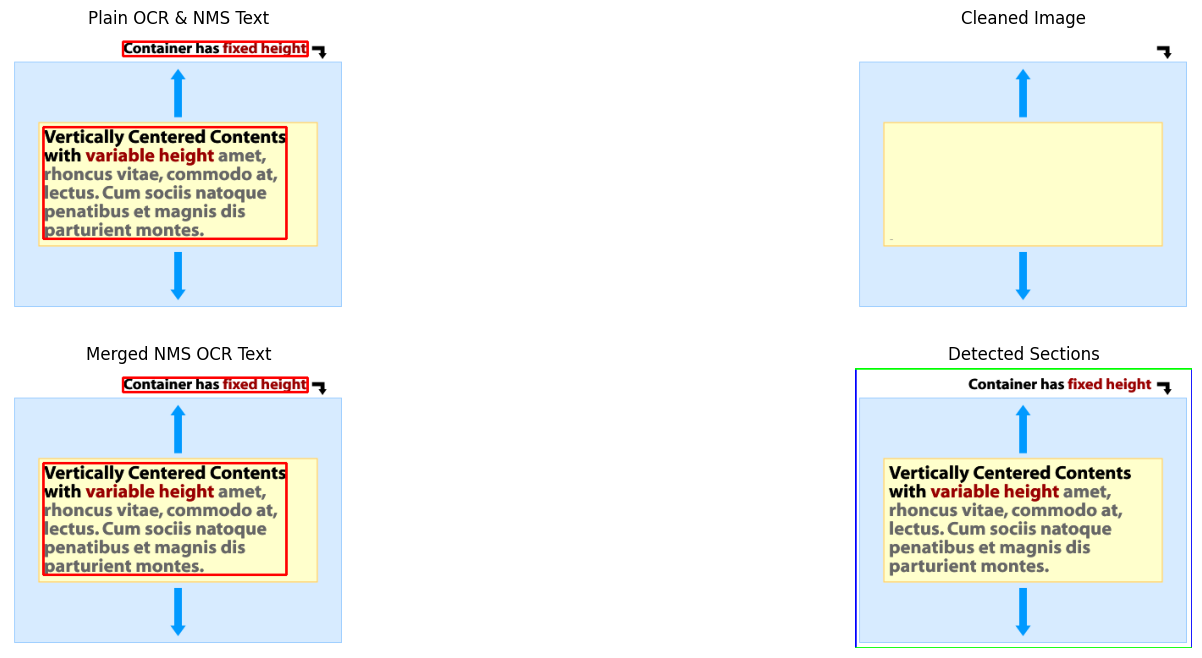

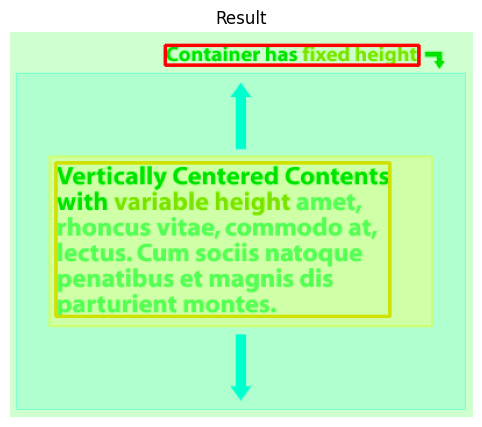

Processing image 0 for row 1
Image name: 176572_8rAnj.png
Uploading ../../images/Temp/176572_8rAnj.png to 176572_8rAnj.png in bucket york-project
File ../../images/Temp/176572_8rAnj.png uploaded to 176572_8rAnj.png.
Google Storage URI: gs://york-project/176572_8rAnj.png
Image URI: gs://york-project/176572_8rAnj.png
Detected paragraphs: 10
Detected sections: [array([  0, 201]), array([  0, 112, 256])]
Detected rectangles: [{'bounds': [(0, 0), (201, 112)]}, {'bounds': [(0, 112), (201, 256)]}]
Question: I have a UI widget that needs to be put in an IFRAME both for performance reasons and so we can syndicate it out to affiliate sites easily. The UI for the widget includes tool-tips that display over the top of other page content. See screenshot below or go to the site to see it in action.  Is there any way to make content from within the IFRAME overlap the parent frame's content? IMAGE_0
Citation: No answer
Explanation: No answer
No citation found.
Processing image 0 for row 2
Image name: 

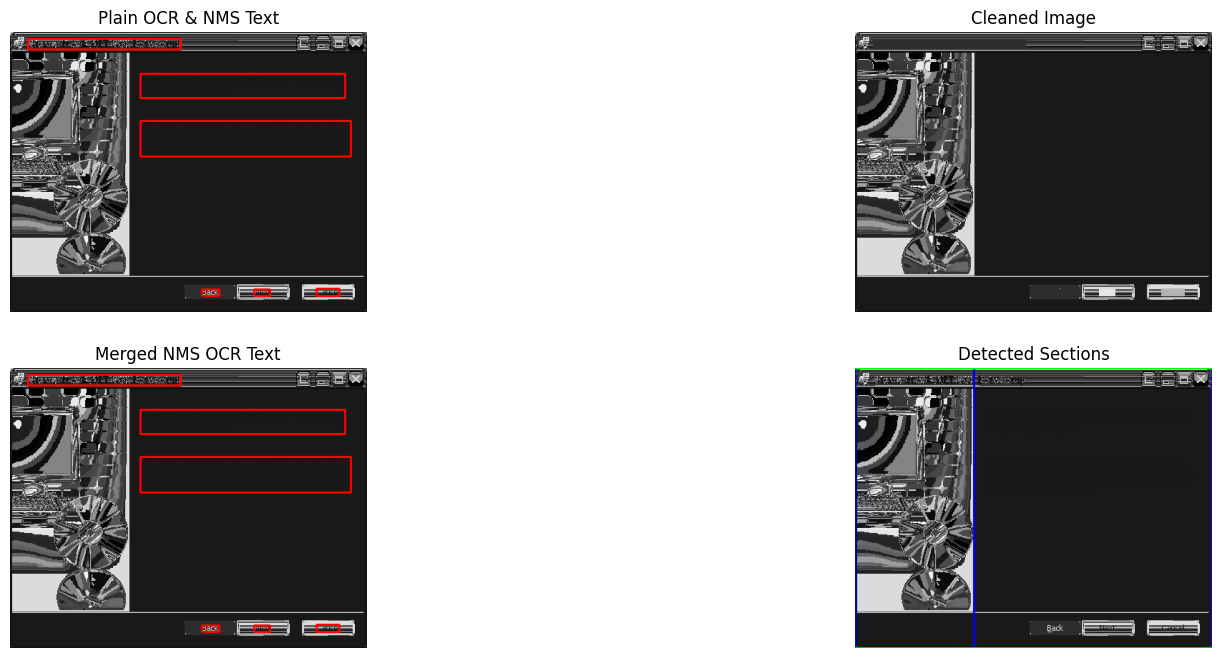

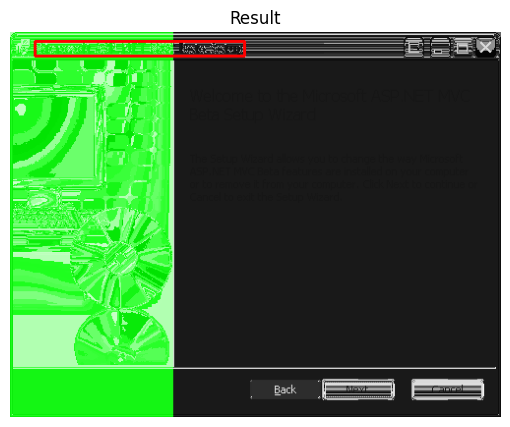

Processing image 0 for row 4
Image name: 332365_G0ifh.png
Uploading ../../images/Temp/332365_G0ifh.png to 332365_G0ifh.png in bucket york-project
File ../../images/Temp/332365_G0ifh.png uploaded to 332365_G0ifh.png.
Google Storage URI: gs://york-project/332365_G0ifh.png
Image URI: gs://york-project/332365_G0ifh.png
Grayscale image detected.
Detected paragraphs: 6
Detected sections: [array([  0, 148, 309, 489, 666]), array([  0, 205])]
Detected rectangles: [{'bounds': [(0, 0), (148, 205)]}, {'bounds': [(148, 0), (309, 205)]}, {'bounds': [(309, 0), (489, 205)]}, {'bounds': [(489, 0), (666, 205)]}]
Question: Just looking at: IMAGE_0 What does this SQL do: I know both ' and -- are for comments, but doesn't the word DROP get commented as well since it is part of the same line?
Citation: Robert'); DROP
Explanation: The SQL code is attempting to drop the "Students" table after the single quote closes the string.
Paragraph ID: 2


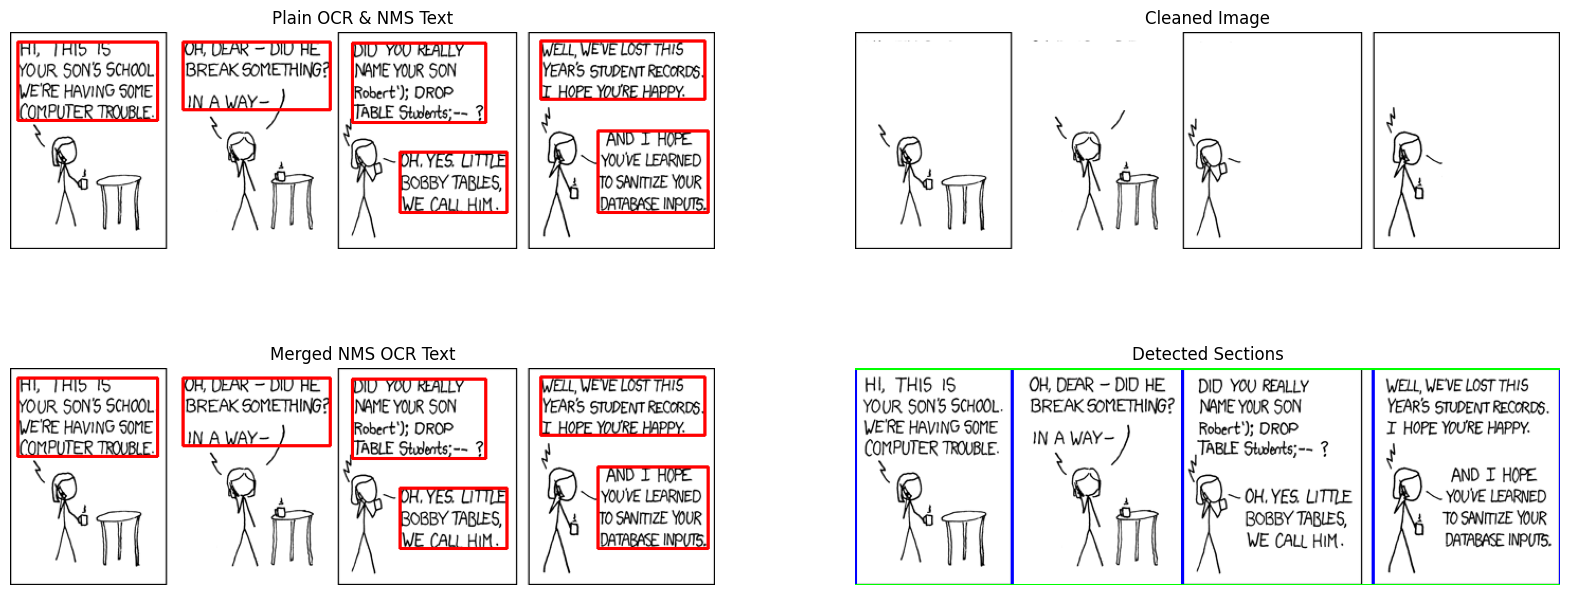

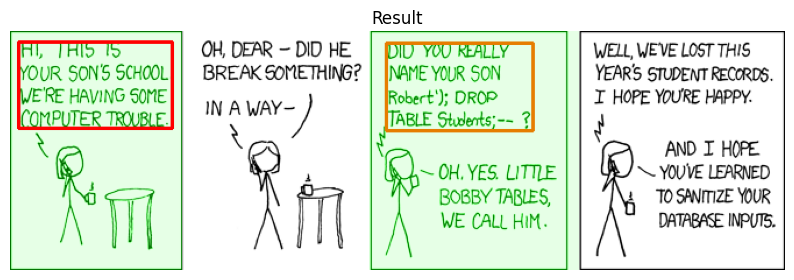

Processing image 0 for row 5
Image name: 398299_kjR4H.png
Uploading ../../images/Temp/398299_kjR4H.png to 398299_kjR4H.png in bucket york-project
File ../../images/Temp/398299_kjR4H.png uploaded to 398299_kjR4H.png.
Google Storage URI: gs://york-project/398299_kjR4H.png
Image URI: gs://york-project/398299_kjR4H.png
Detected paragraphs: 4
Detected sections: [array([  0,  25, 136]), array([  0, 145])]
Detected rectangles: [{'bounds': [(0, 0), (25, 145)]}, {'bounds': [(25, 0), (136, 145)]}]
[(0, 0), (25, 78)] (25, 78) [(25, 0), (136, 78)] (25, 78)
[(25, 0), (136, 78)] (25, 78) [(0, 78), (25, 145)] (25, 78)
[(0, 78), (25, 145)] (25, 78) [(25, 78), (136, 145)] (25, 78)
Question: A friend was in need of an algorithm that would let him loop through the elements of an NxM matrix (N and M are odd). I came up with a solution, but I wanted to see if my fellow SO'ers could come up with a better solution. I'm posting my solution as an answer to this question. Example Output: For a 3x3 matrix, the o

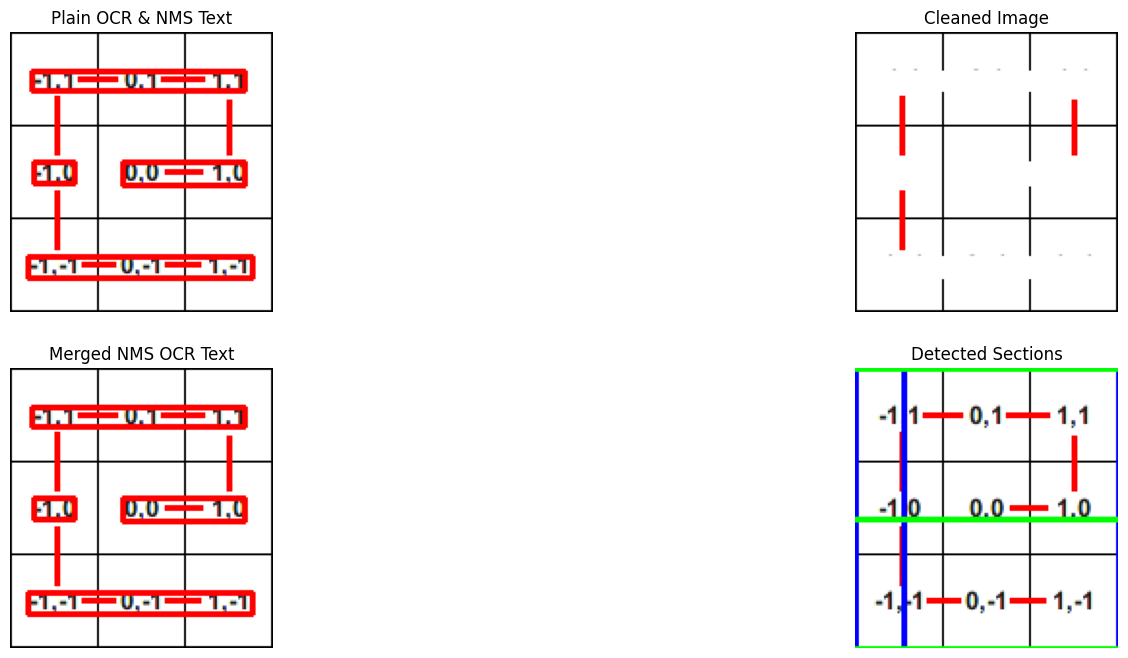

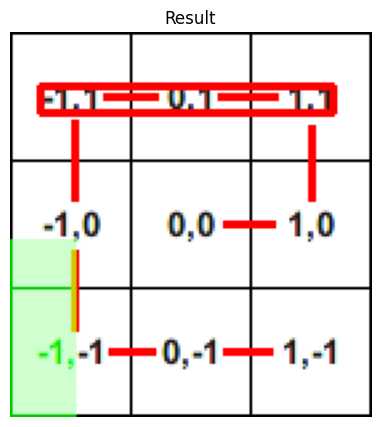

Processing image 0 for row 6
Image name: 409259_gD4cE.png
Uploading ../../images/Temp/409259_gD4cE.png to 409259_gD4cE.png in bucket york-project
File ../../images/Temp/409259_gD4cE.png uploaded to 409259_gD4cE.png.
Google Storage URI: gs://york-project/409259_gD4cE.png
Image URI: gs://york-project/409259_gD4cE.png
Detected paragraphs: 3
Detected sections: [array([  0, 312]), array([  0,  51, 100])]
Detected rectangles: [{'bounds': [(0, 0), (312, 51)]}, {'bounds': [(0, 51), (312, 100)]}]
Question: I'm trying to do that for a couple of days now, and after reading tons of messages of people trying to do that too, I'm still unable to have a fully working UITextField in some of my UITableViewCells, just like in this example:  IMAGE_0 Either I have the form working but the text is not visible (although I set its color to blue), the keyboard goes on the field when I click on it and I haven't been able to correctly implement the keyboard events. I tried with a bunch of examples from Apple (ma

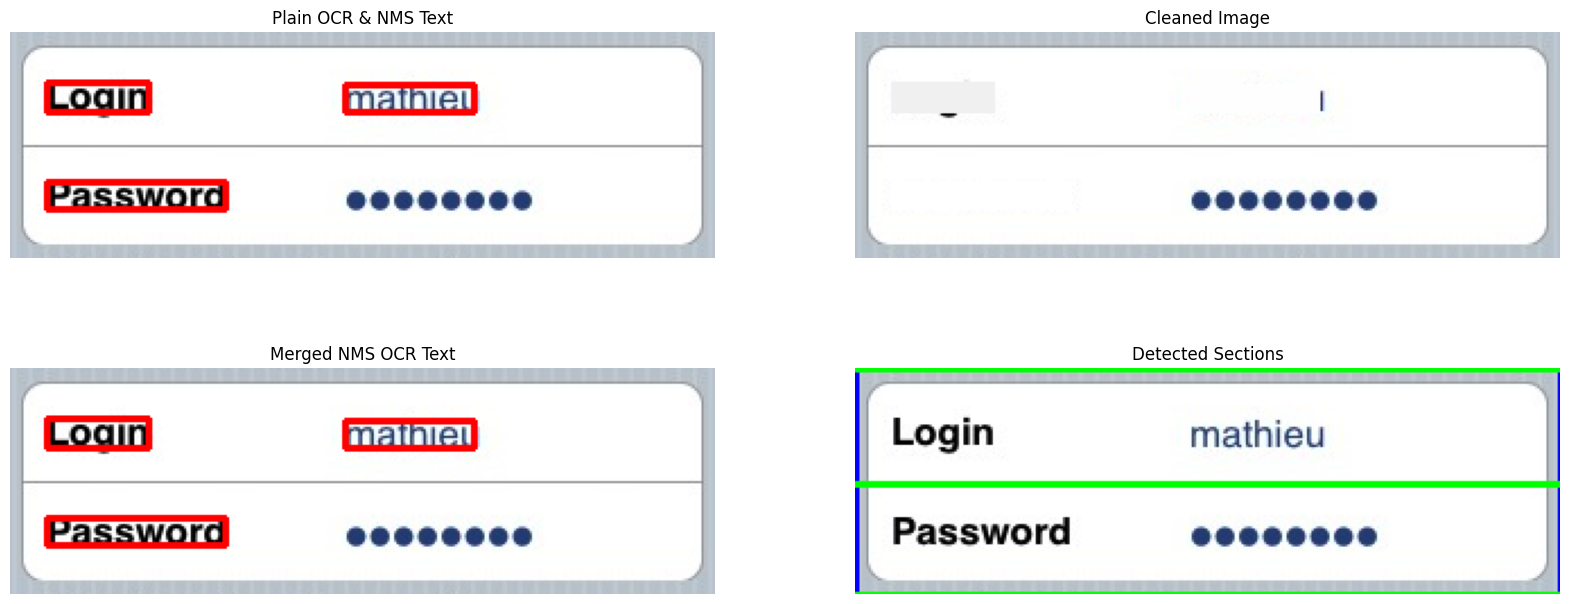

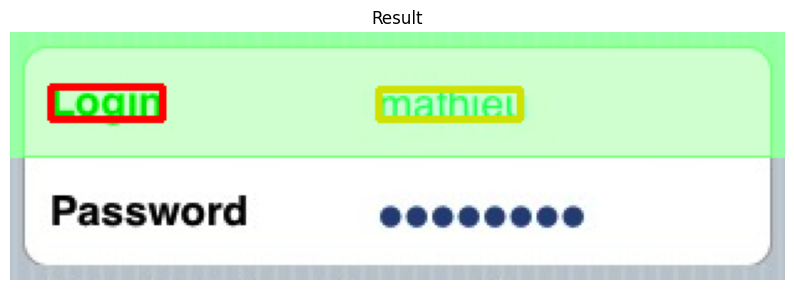

Processing image 0 for row 7
Image name: 465950_ocrX1.png
Uploading ../../images/Temp/465950_ocrX1.png to 465950_ocrX1.png in bucket york-project
File ../../images/Temp/465950_ocrX1.png uploaded to 465950_ocrX1.png.
Google Storage URI: gs://york-project/465950_ocrX1.png
Image URI: gs://york-project/465950_ocrX1.png
Detected paragraphs: 32
Detected sections: [array([   0,  794, 1211]), array([  0, 131, 325])]
Detected rectangles: [{'bounds': [(0, 0), (794, 131)]}, {'bounds': [(794, 0), (1211, 131)]}, {'bounds': [(0, 131), (794, 325)]}, {'bounds': [(794, 131), (1211, 325)]}]
Question: IMAGE_0 Mainad has a valid height and width, however it isn't shown like subad1/subad2. Which are in essence exactly the same! (just a different background image). Firebug shows my div as greyed out for some weird reason. Replacing the contents of mainad with just some text doesn't solve the problem (problem isn't related to inner elements)..  What's going on?! :(
Citation: background-image: url(images/main

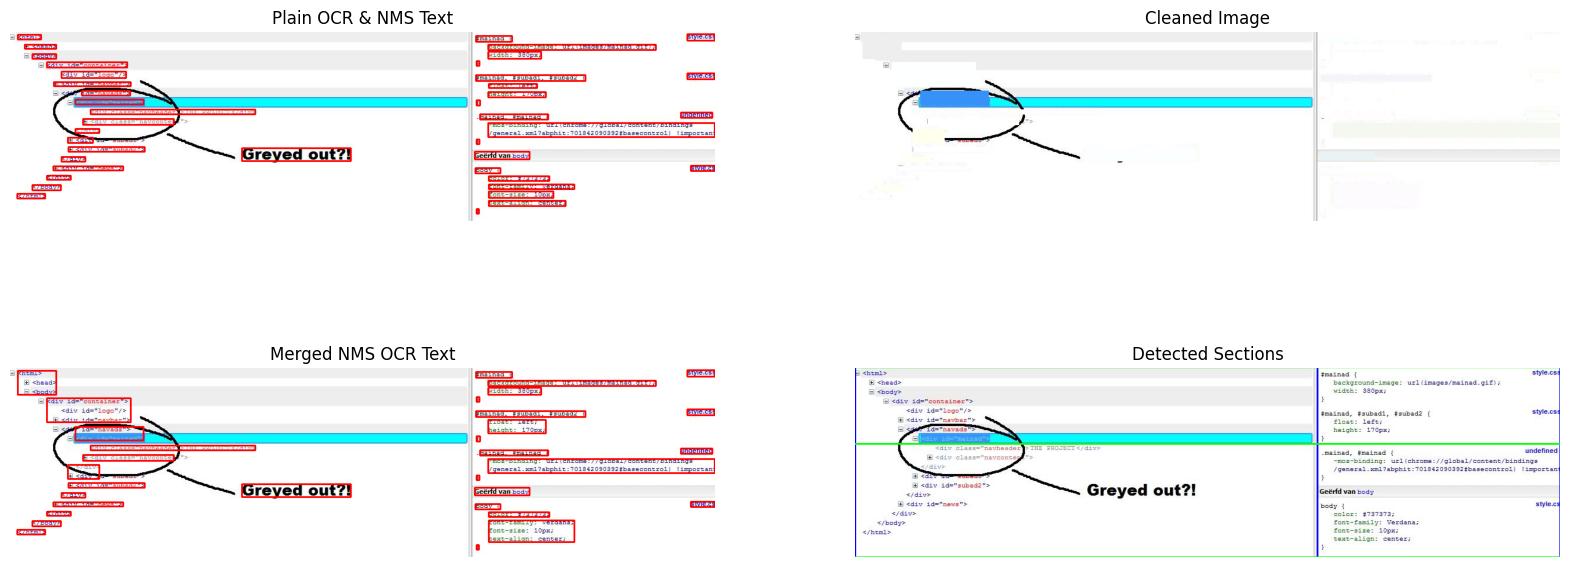

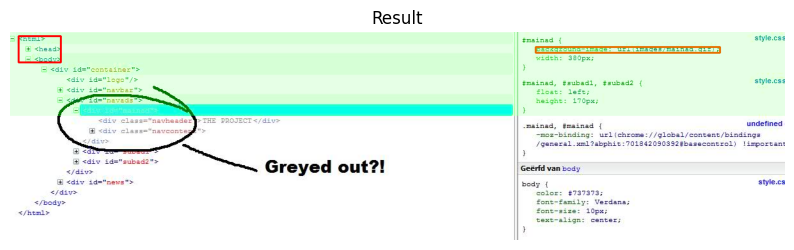

Processing image 0 for row 8
Image name: 493296_wPh0S.png
Uploading ../../images/Temp/493296_wPh0S.png to 493296_wPh0S.png in bucket york-project
File ../../images/Temp/493296_wPh0S.png uploaded to 493296_wPh0S.png.
Google Storage URI: gs://york-project/493296_wPh0S.png
Image URI: gs://york-project/493296_wPh0S.png
Detected paragraphs: 0
Detected sections: [array([  0, 228, 364, 567, 800]), array([  0, 149, 275, 375, 493, 600])]
Detected rectangles: [{'bounds': [(0, 0), (228, 149)]}, {'bounds': [(228, 0), (364, 149)]}, {'bounds': [(364, 0), (567, 149)]}, {'bounds': [(567, 0), (800, 149)]}, {'bounds': [(0, 149), (228, 275)]}, {'bounds': [(228, 149), (364, 275)]}, {'bounds': [(364, 149), (567, 275)]}, {'bounds': [(567, 149), (800, 275)]}, {'bounds': [(0, 275), (228, 375)]}, {'bounds': [(228, 275), (364, 375)]}, {'bounds': [(364, 275), (567, 375)]}, {'bounds': [(567, 275), (800, 375)]}, {'bounds': [(0, 375), (228, 493)]}, {'bounds': [(228, 375), (364, 493)]}, {'bounds': [(364, 375), (567,

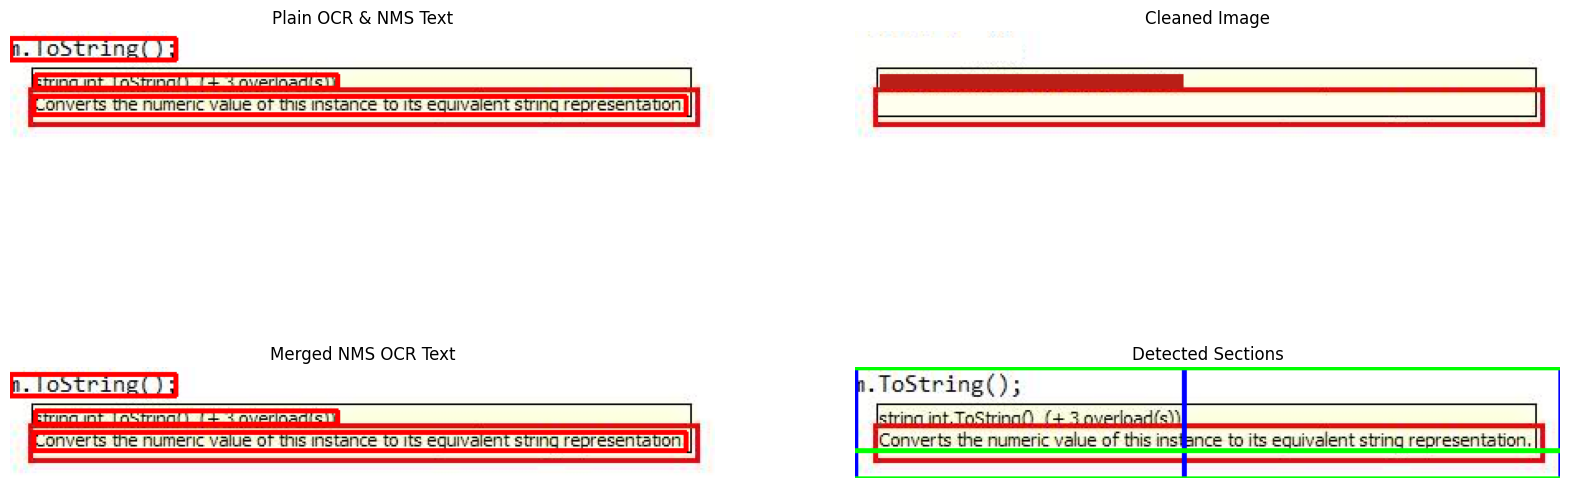

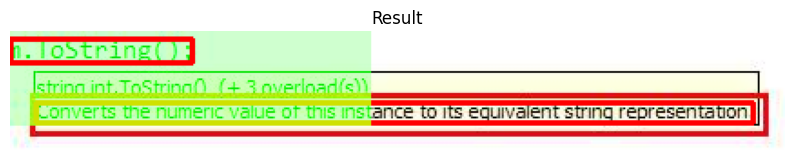

Processing image 0 for row 11
Image name: 796824_e3RRI.png
Uploading ../../images/Temp/796824_e3RRI.png to 796824_e3RRI.png in bucket york-project
File ../../images/Temp/796824_e3RRI.png uploaded to 796824_e3RRI.png.
Google Storage URI: gs://york-project/796824_e3RRI.png
Image URI: gs://york-project/796824_e3RRI.png
Detected paragraphs: 4
Detected sections: [array([  0, 113, 317, 495, 598]), array([  0,  65, 113])]
Detected rectangles: [{'bounds': [(0, 0), (113, 65)]}, {'bounds': [(113, 0), (317, 65)]}, {'bounds': [(317, 0), (495, 65)]}, {'bounds': [(495, 0), (598, 65)]}, {'bounds': [(0, 65), (113, 113)]}, {'bounds': [(113, 65), (317, 113)]}, {'bounds': [(317, 65), (495, 113)]}, {'bounds': [(495, 65), (598, 113)]}]
Question: I love the syntax of railroad diagrams on json.org which are a graphical representation of the BNF language. I haven't found any tools that can produce results as eloquently. IMAGE_0 IMAGE_1


KeyboardInterrupt: 

In [81]:
# data = pd.DataFrame({
#     "Id": [1],
#     "ImageUrl": ["/home/wfd/Desktop/York/notebooks/MLLM/1-eOkU7BNyO5Avh1xu62FxQw.png"],
#     "NewBody": ["What is the price"],
# })

# Shuffle the dataset
# data = data.sample(frac=1)

for index, row in data.iterrows():
    for i, url in enumerate(row['ImageUrl']):
        print(f"Processing image {i} for row {index}")
        img_name = get_image_name_from_url(row["Id"], url)
        img_path = f"../../images/Temp/{img_name}"
        print(f"Image name: {img_name}")

        img_uri = upload_to_gcs(img_path, img_name)
        print(f"Image URI: {img_uri}")

        with io.open(img_path, "rb") as image_file:
            content = image_file.read()
        VISION_image = vision.Image(content=content)

        ### OCR
        OCR_paragraphs = detect_text(VISION_image, project_id)
        FILTERED_paragraphs = non_max_suppression(OCR_paragraphs, 0.2)
        SORTED_paragraphs = sort_bounding_boxes(FILTERED_paragraphs)
        MERGED_paragraphs = merge_boxes(SORTED_paragraphs, threshold=0.002, pixel_threshold=20, max_y_distance=10)
        MERGED_paragraphs = non_max_suppression(MERGED_paragraphs, 0.2)

        ### Image processing
        NP_image = get_np_image(img_path);
        OCR_ORIGINAL_HL_image = highlight_boxes(NP_image, FILTERED_paragraphs)
        OCR_MERGED_HL_image = highlight_boxes(NP_image, MERGED_paragraphs)
        print(f"Detected paragraphs: {len(MERGED_paragraphs)}")

        ### Section detection
        CLEANED_image = highlight_boxes(NP_image, MERGED_paragraphs, thickness=-1)
        SECTIONS = detect_sections_refined(CLEANED_image, min_section_ratio=0.15)
        RECTANGLES = get_boxes(SECTIONS)
        print(f"Detected sections: {SECTIONS}")
        print(f"Detected rectangles: {RECTANGLES}")

        ### Text processing
        SORTED_paragraphs = sort_bounding_boxes(MERGED_paragraphs)
        TEXT_sections, SECTIONS, RECTANGLES = process_text_sections(SORTED_paragraphs, SECTIONS, RECTANGLES)
        SECTIONS_HL_image = draw_boundaries(NP_image, SECTIONS)

        # ### Retrieve question
        question = row['NewBody']
        print(f"Question: {question}")

        ### Ask question
        sleep(27.5)
        response = ask_question(question, img_uri)

        #! IMPLEMENT SELFCHECKGPT (WILL MAKE EACH IMAGE TAKE AT LEAST 3 times as long TO PROCESS)

        ### Extract response
        text_1, text_2, output_type = extract_response(response)
        print(f"Citation: {text_1}")
        print(f"Explanation: {text_2}")

        # If nothing is found, skip the image
        if text_1 is None or text_1 == "No answer":
            print("No citation found.")
            # Save everything to a csv file
            with open("../../data/Results.csv", "a") as file:
                file.write(f'{row['Id']},"{img_name}","{question}",{None},{None},"{paragraph_id}"\n')
            continue
        
        ### Find the bounding box of the paragraph
        RESULT_image = NP_image.copy()
        
        #! IMPLEMENT LOOK_FOR_TEXT, FUZZY OR NOT
        paragraph_id, start_idx, dist = look_for_text(text_1, SORTED_paragraphs, len(tuple(text_1))/3)
        # paragraph_id, start_idx, dist = look_for_text_fuzzy(text_1, SORTED_paragraphs, 10)

        # If the citation is not found, skip the image
        if paragraph_id == None:
            print("No matching text found.")
            # Save everything to a csv file
            with open("../../data/Results.csv", "a") as file:
                file.write(f'{row['Id']},"{img_name}","{question}","{text_1}","{text_2}",{None}\n')
            continue
        
        print(f"Paragraph ID: {paragraph_id}")
        if paragraph_id is not None:
            RESULT_image = highlight_boxes(RESULT_image, [SORTED_paragraphs[paragraph_id]], thickness=2)
            ### Highlight the section
            RESULT_image = highlight_section(RESULT_image, RECTANGLES, SORTED_paragraphs, paragraph_id, dist)

        #! akdmaksdka
        try:
            RESULT_image = highlight_section(RESULT_image, RECTANGLES, SORTED_paragraphs, 0, 1)
            RESULT_image = highlight_boxes(RESULT_image, [SORTED_paragraphs[0]], thickness=2)
        except:
            pass

        ## Display the images
        fig, ax = plt.subplots(2, 2, figsize=(20, 8))
        ax[0, 0].imshow(cv2.cvtColor(OCR_ORIGINAL_HL_image, cv2.COLOR_BGR2RGB))
        ax[0, 0].set_title("Plain OCR & NMS Text")
        ax[0, 0].axis("off")

        ax[0, 1].imshow(cv2.cvtColor(CLEANED_image, cv2.COLOR_BGR2RGB))
        ax[0, 1].set_title("Cleaned Image")
        ax[0, 1].axis("off")

        ax[1, 0].imshow(cv2.cvtColor(OCR_MERGED_HL_image, cv2.COLOR_BGR2RGB))
        ax[1, 0].set_title("Merged NMS OCR Text")
        ax[1, 0].axis("off")

        ax[1, 1].imshow(cv2.cvtColor(SECTIONS_HL_image, cv2.COLOR_BGR2RGB))
        ax[1, 1].set_title("Detected Sections")
        ax[1, 1].axis("off")

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(RESULT_image, cv2.COLOR_BGR2RGB))
        plt.title("Result")
        plt.axis("off")

        folders = [
            "OCR_ORIGINAL", "OCR_MERGED", "CLEANED", "SECTIONS", "RESULT",
        ]

        images = [
            OCR_ORIGINAL_HL_image, OCR_MERGED_HL_image, CLEANED_image, SECTIONS_HL_image, RESULT_image,
        ]

        # Save everything to a csv file
        with open("../../data/Results.csv", "a") as file:
            file.write(f'{row['Id']},"{img_name}","{question}","{text_1}","{text_2}","{paragraph_id}"\n')

        for i, folder in enumerate(folders):
            plt.imsave(f"../../images/Output/{folder}/{img_name}", images[i])

        plt.show()
        break